In [1]:
# === IMPORTS ===
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F
from tqdm.notebook import tqdm
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import ast


In [2]:
from google.colab import drive
drive.mount('/content/drive')

DRIVE_BASE_PATH = "/content/drive/MyDrive/enem_tcc_resultados"
os.makedirs(DRIVE_BASE_PATH, exist_ok=True)
print(f"✓ Google Drive montado. Resultados serão salvos em: {DRIVE_BASE_PATH}")

SAVE_DIR = os.path.join(DRIVE_BASE_PATH, "grade_expectation", "finetuning_originals")
os.makedirs(SAVE_DIR, exist_ok=True)
print(f"✓ Diretório de resultados: {SAVE_DIR}")


Mounted at /content/drive
✓ Google Drive montado. Resultados serão salvos em: /content/drive/MyDrive/enem_tcc_resultados
✓ Diretório de resultados: /content/drive/MyDrive/enem_tcc_resultados/grade_expectation/finetuning_originals


In [3]:
# === CARREGAR DATASET ===
print("Carregando o dataset...")
dataset = load_dataset("laisnuto/self-collected-ENEM-dataset", split="train")

# Filtrar apenas os anos de teste usados no fine-tuning
anos_teste = [2016, 2018, 2022, 2023]
df_full = dataset.to_pandas()
df_test = df_full[df_full["ano"].isin(anos_teste)].reset_index(drop=True)
dataset = dataset.filter(lambda x: x["ano"] in anos_teste)

print(f"✓ Dataset carregado: {len(df_test)} redações")
dataset.to_pandas().head()


Carregando o dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


enem_dataset.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/157 [00:00<?, ? examples/s]

Filter:   0%|          | 0/157 [00:00<?, ? examples/s]

✓ Dataset carregado: 43 redações


,ano,texto,notas,nota_final
0,2018,"Liberdade na Internet\n\nNo século XXI, a soci...","[120, 120, 160, 160, 160]",720.0
1,2018,O compartilhamento de dados na internet é algo...,"[160, 120, 120, 140, 140]",680.0
2,2023,"A Constituição Federal de 1988, norma de maior...","[180, 200, 200, 200, 200]",980.0
3,2018,A internet veio para trazer a informação mais ...,"[140, 200, 140, 160, 120]",760.0
4,2022,"No contexto social brasileiro, muito tem sido ...","[160, 200, 180, 200, 200]",940.0


In [4]:
# === CONFIGURAÇÃO DOS MODELOS ===
device = "cuda" if torch.cuda.is_available() else "cpu"
if torch.cuda.is_available():
    print(f"✅ GPU disponível: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ GPU não disponível, usando CPU")

competencias = [1, 2, 3, 4, 5]

model_types = {
    "mbert": "laisnuto/finetuning-with-official-enem-essays-mbert-C{}",
    "bertugues": "laisnuto/finetuning-with-official-enem-essays-bertugues-C{}",
    "bertimbau": "laisnuto/finetuning-with-official-enem-essays-bertimbau-C{}"
}

# Carregar modelos e tokenizers
models = {}
tokenizers = {}

for model_key, model_path_template in model_types.items():
    print(f"\n📦 Carregando modelos: {model_key}")
    models[model_key] = {}
    tokenizers[model_key] = {}

    for c in competencias:
        comp_key = f"C{c}"
        try:
            model_name = model_path_template.format(c)
            print(f"➡️ {comp_key} | Modelo: {model_name}")

            if model_key == "bertimbau":
                tokenizer = AutoTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")
            else:
                tokenizer = AutoTokenizer.from_pretrained(model_name)

            # Configurar max_length explicitamente
            if not hasattr(tokenizer, 'model_max_length') or tokenizer.model_max_length is None:
                tokenizer.model_max_length = 512
            elif tokenizer.model_max_length > 512:
                tokenizer.model_max_length = 512

            model = AutoModelForSequenceClassification.from_pretrained(model_name)
            model = model.eval()

            if torch.cuda.is_available():
                model = model.to(device)
                print(f"   ✓ Modelo movido para GPU")

            models[model_key][comp_key] = model
            tokenizers[model_key][comp_key] = tokenizer
        except Exception as e:
            print(f"❌ Erro ao carregar modelo {model_name}: {e}")
            models[model_key][comp_key] = None
            tokenizers[model_key][comp_key] = None

print("\n✅ Carregamento concluído!")


⚠️ GPU não disponível, usando CPU

📦 Carregando modelos: mbert
➡️ C1 | Modelo: laisnuto/finetuning-with-official-enem-essays-mbert-C1


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

➡️ C2 | Modelo: laisnuto/finetuning-with-official-enem-essays-mbert-C2


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

➡️ C3 | Modelo: laisnuto/finetuning-with-official-enem-essays-mbert-C3


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

➡️ C4 | Modelo: laisnuto/finetuning-with-official-enem-essays-mbert-C4


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

➡️ C5 | Modelo: laisnuto/finetuning-with-official-enem-essays-mbert-C5


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]


📦 Carregando modelos: bertugues
➡️ C1 | Modelo: laisnuto/finetuning-with-official-enem-essays-bertugues-C1


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

➡️ C2 | Modelo: laisnuto/finetuning-with-official-enem-essays-bertugues-C2


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

➡️ C3 | Modelo: laisnuto/finetuning-with-official-enem-essays-bertugues-C3


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

➡️ C4 | Modelo: laisnuto/finetuning-with-official-enem-essays-bertugues-C4


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

➡️ C5 | Modelo: laisnuto/finetuning-with-official-enem-essays-bertugues-C5


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]


📦 Carregando modelos: bertimbau
➡️ C1 | Modelo: laisnuto/finetuning-with-official-enem-essays-bertimbau-C1


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

➡️ C2 | Modelo: laisnuto/finetuning-with-official-enem-essays-bertimbau-C2


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

➡️ C3 | Modelo: laisnuto/finetuning-with-official-enem-essays-bertimbau-C3


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

➡️ C4 | Modelo: laisnuto/finetuning-with-official-enem-essays-bertimbau-C4


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

➡️ C5 | Modelo: laisnuto/finetuning-with-official-enem-essays-bertimbau-C5


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]


✅ Carregamento concluído!


In [5]:
# === FUNÇÃO PARA CALCULAR NOTA ESPERADA ===
def calcular_nota_esperada(model, tokenizer, text, device="cpu"):
    """
    Calcula a nota esperada usando softmax e probabilidades.
    Retorna a nota esperada como float.
    """
    # Tokenizar texto
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Obter saída do modelo
    with torch.no_grad():
        outputs = model(**inputs)

    # Calcular probabilidades usando softmax
    probabilities = F.softmax(outputs.logits, dim=-1)[0]

    # Calcular nota esperada: 0*P(0) + 40*P(40) + 80*P(80) + 120*P(120) + 160*P(160) + 200*P(200)
    nota_esperada = (0 * probabilities[0] +
                     40 * probabilities[1] +
                     80 * probabilities[2] +
                     120 * probabilities[3] +
                     160 * probabilities[4] +
                     200 * probabilities[5]).item()

    return nota_esperada


In [6]:
# === CALCULAR NOTAS ESPERADAS ===
resultados_por_modelo = {}

for model_key in model_types.keys():
    print(f"\n📊 Calculando notas esperadas para: {model_key}")

    csv_path = os.path.join(SAVE_DIR, f"notas_esperadas_{model_key}_finetuning_originals.csv")

    # Verificar se já existe CSV
    if os.path.exists(csv_path):
        print(f"✅ Carregando notas esperadas existentes de {csv_path}")
        df_resultados = pd.read_csv(csv_path)
        print(f"   Carregadas {len(df_resultados)} notas esperadas")
        resultados_por_modelo[model_key] = df_resultados
        continue

    # Calcular notas esperadas
    textos = dataset["texto"]
    notas_esperadas = {f"C{c}": [] for c in competencias}

    for texto in tqdm(textos, desc=f"Processando {model_key}"):
        for c in competencias:
            comp_key = f"C{c}"

            if models[model_key][comp_key] is None:
                notas_esperadas[comp_key].append(np.nan)
                continue

            try:
                nota = calcular_nota_esperada(
                    models[model_key][comp_key],
                    tokenizers[model_key][comp_key],
                    texto,
                    device
                )
                notas_esperadas[comp_key].append(nota)
            except Exception as e:
                print(f"⚠️ Erro ao calcular nota para {comp_key}: {e}")
                notas_esperadas[comp_key].append(np.nan)

    # Criar DataFrame com resultados
    df_resultados = dataset.to_pandas().copy()
    for c in competencias:
        comp_key = f"C{c}"
        df_resultados[f"nota_esperada_{comp_key}"] = notas_esperadas[comp_key]

    # Salvar CSV
    df_resultados.to_csv(csv_path, index=False)
    print(f"✅ Notas esperadas salvas em: {csv_path}")

    resultados_por_modelo[model_key] = df_resultados



📊 Calculando notas esperadas para: mbert


Processando mbert:   0%|          | 0/43 [00:00<?, ?it/s]

✅ Notas esperadas salvas em: /content/drive/MyDrive/enem_tcc_resultados/grade_expectation/finetuning_originals/notas_esperadas_mbert_finetuning_originals.csv

📊 Calculando notas esperadas para: bertugues


Processando bertugues:   0%|          | 0/43 [00:00<?, ?it/s]

✅ Notas esperadas salvas em: /content/drive/MyDrive/enem_tcc_resultados/grade_expectation/finetuning_originals/notas_esperadas_bertugues_finetuning_originals.csv

📊 Calculando notas esperadas para: bertimbau


Processando bertimbau:   0%|          | 0/43 [00:00<?, ?it/s]

✅ Notas esperadas salvas em: /content/drive/MyDrive/enem_tcc_resultados/grade_expectation/finetuning_originals/notas_esperadas_bertimbau_finetuning_originals.csv



📈 Gerando gráficos para: mbert
✅ Gráfico salvo em: /content/drive/MyDrive/enem_tcc_resultados/grade_expectation/finetuning_originals/grafico_nota_real_vs_esperada_mbert_finetuning_originals.png


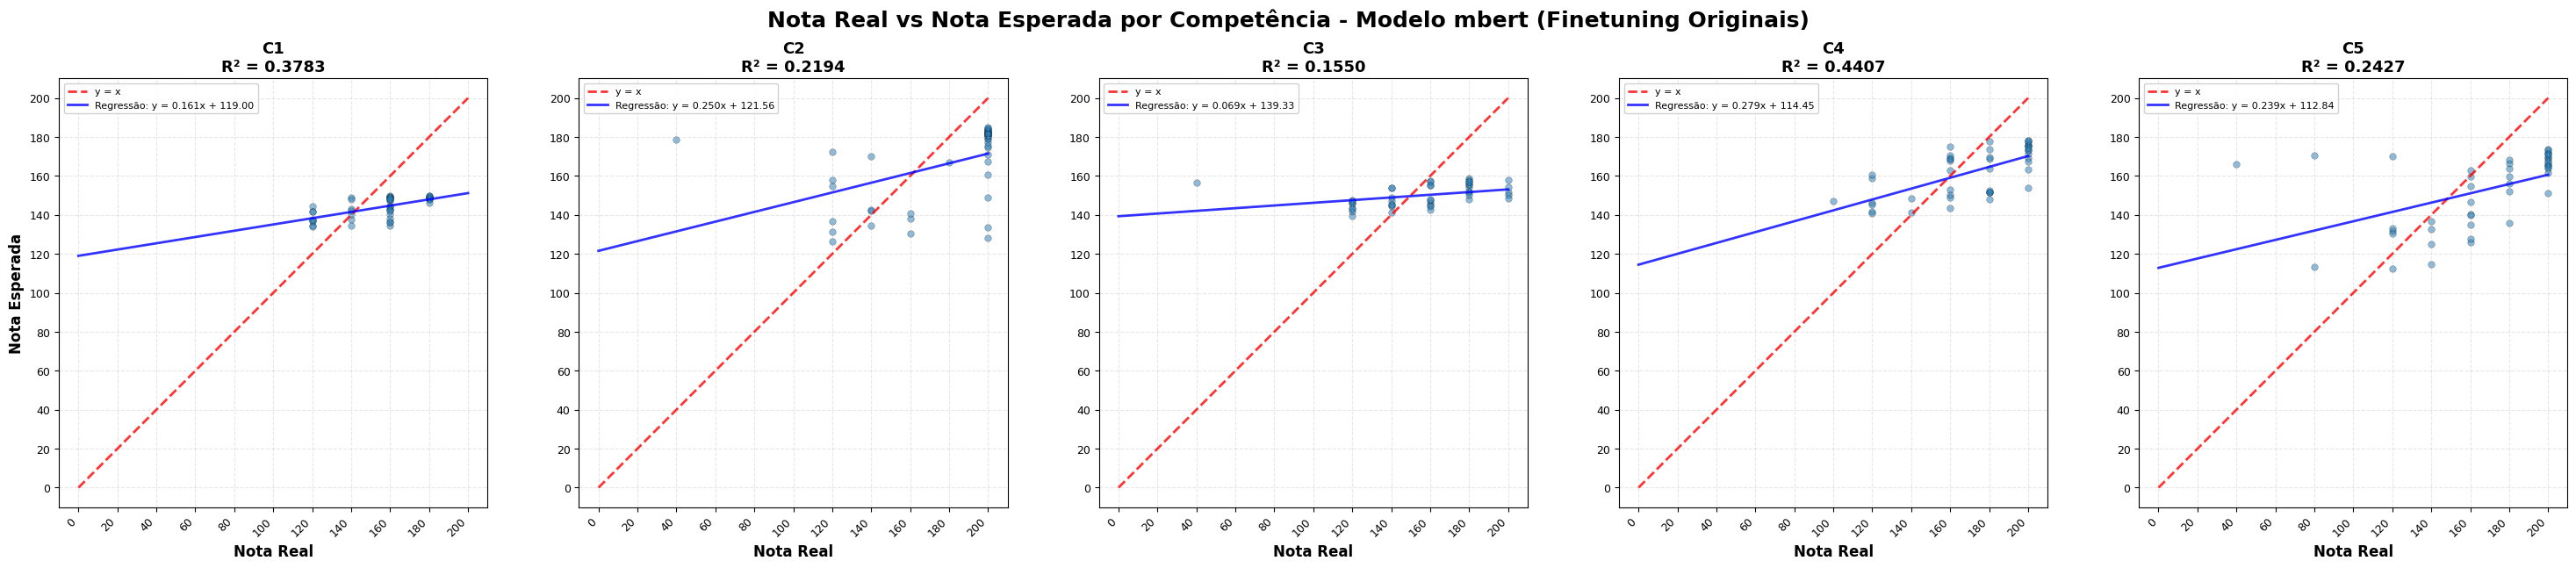


📊 Resumo das Métricas por Competência - MBERT:
Competência  R²          
------------------------------------------------------------
C1           0.3783      
C2           0.2194      
C3           0.1550      
C4           0.4407      
C5           0.2427      
------------------------------------------------------------
MÉDIO        0.2872      

📈 Gerando gráficos para: bertugues
✅ Gráfico salvo em: /content/drive/MyDrive/enem_tcc_resultados/grade_expectation/finetuning_originals/grafico_nota_real_vs_esperada_bertugues_finetuning_originals.png


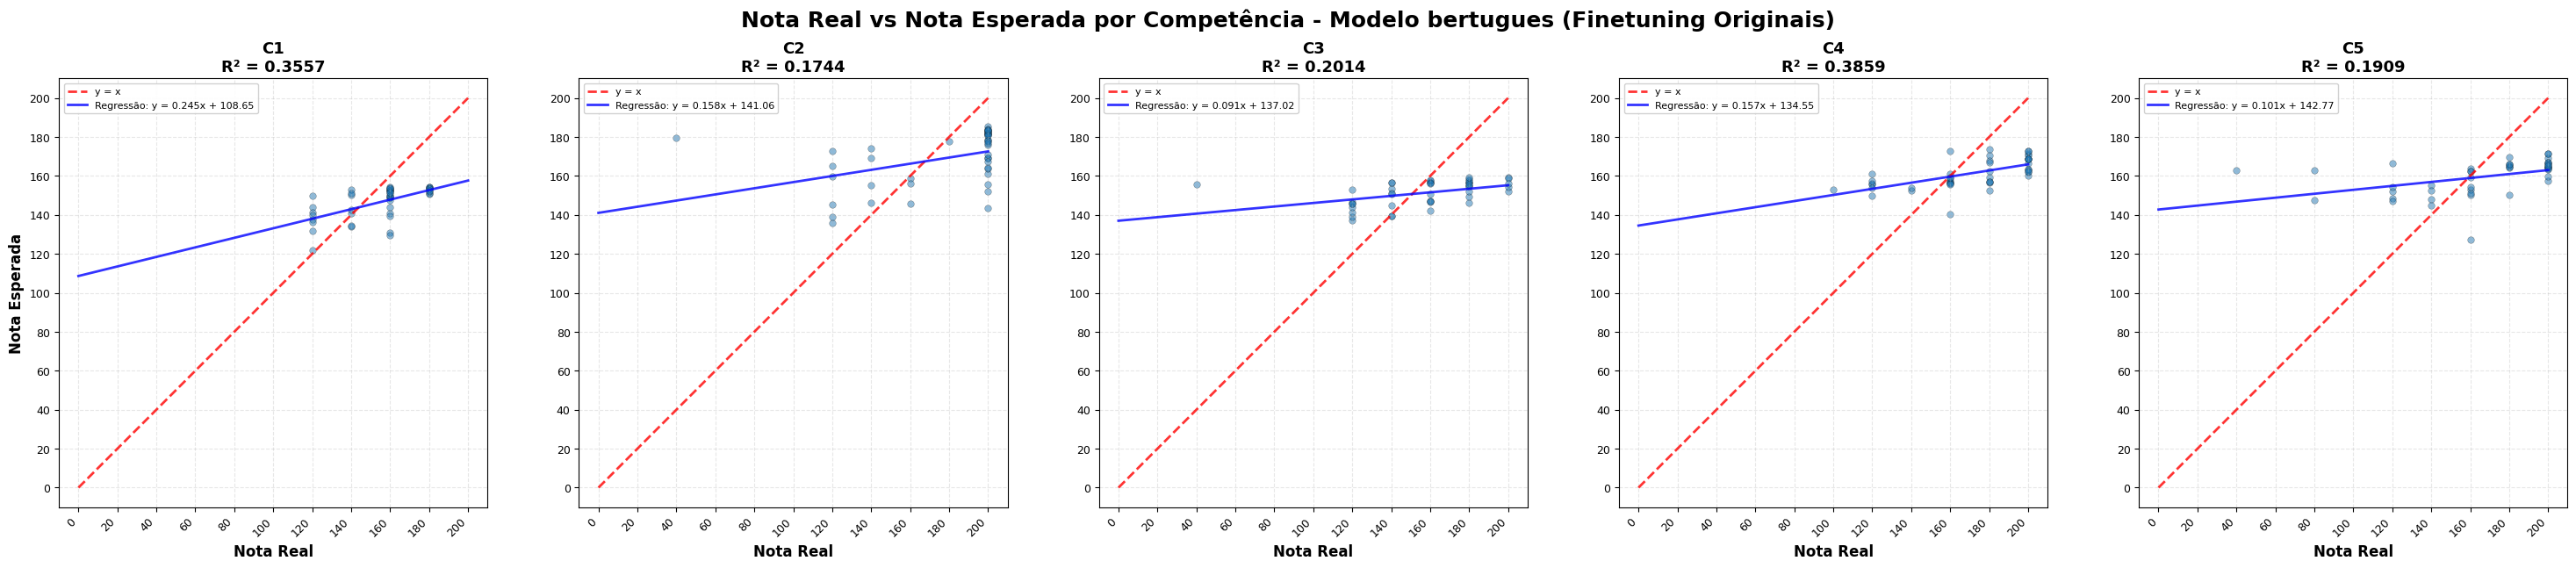


📊 Resumo das Métricas por Competência - BERTUGUES:
Competência  R²          
------------------------------------------------------------
C1           0.3557      
C2           0.1744      
C3           0.2014      
C4           0.3859      
C5           0.1909      
------------------------------------------------------------
MÉDIO        0.2616      

📈 Gerando gráficos para: bertimbau
✅ Gráfico salvo em: /content/drive/MyDrive/enem_tcc_resultados/grade_expectation/finetuning_originals/grafico_nota_real_vs_esperada_bertimbau_finetuning_originals.png


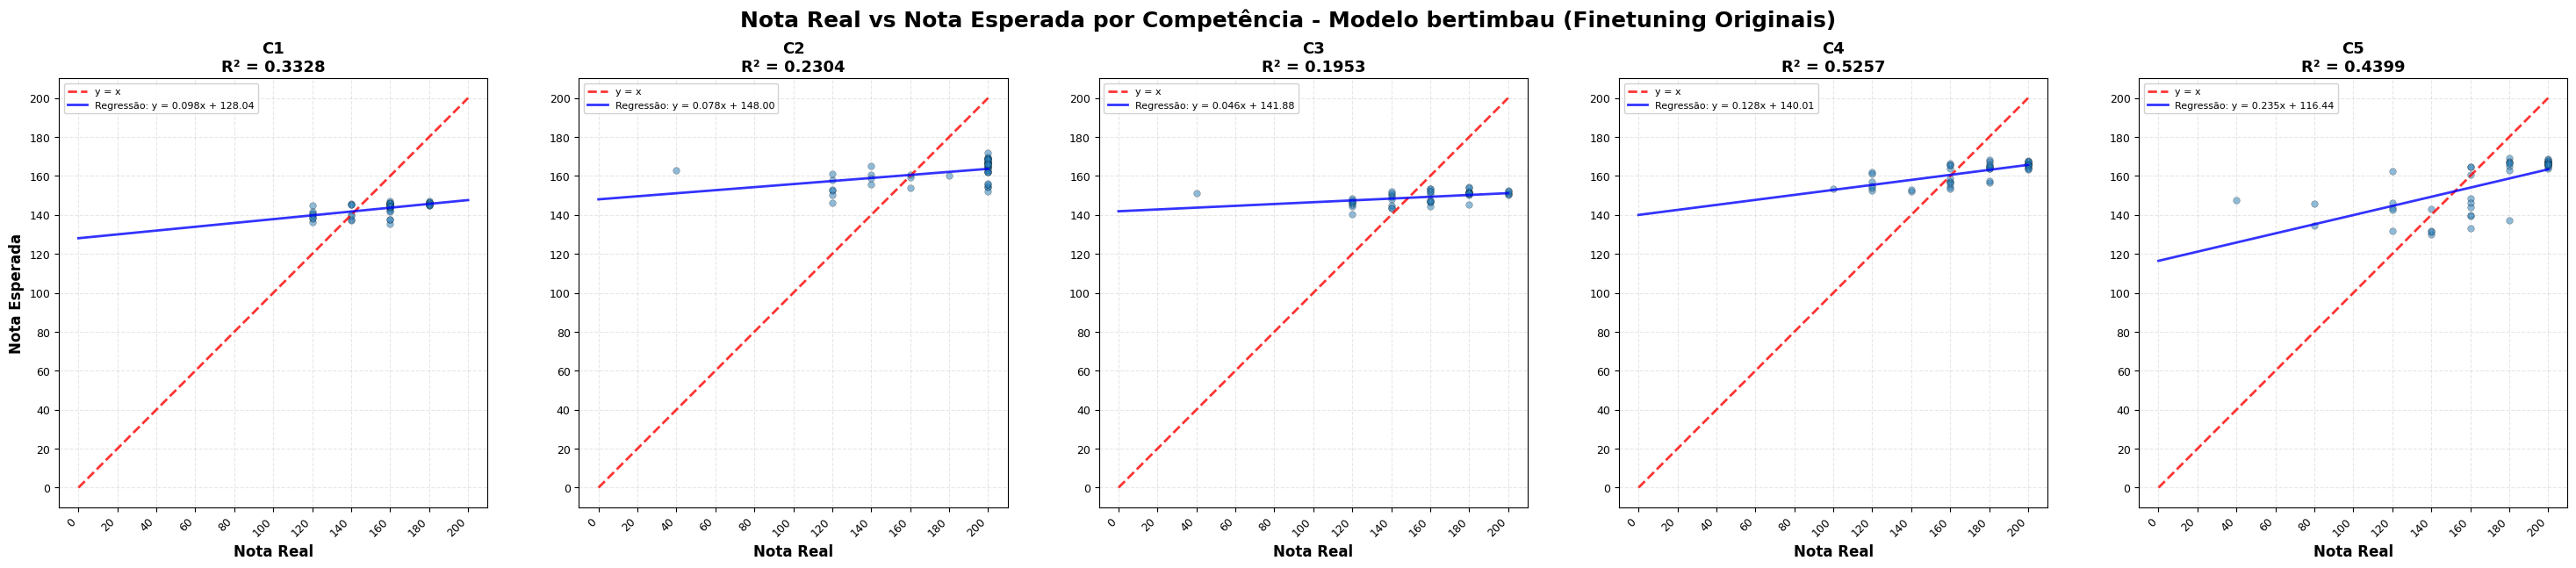


📊 Resumo das Métricas por Competência - BERTIMBAU:
Competência  R²          
------------------------------------------------------------
C1           0.3328      
C2           0.2304      
C3           0.1953      
C4           0.5257      
C5           0.4399      
------------------------------------------------------------
MÉDIO        0.3448      


In [7]:
# === PLOTAR GRÁFICOS ===
for model_key, df_resultados in resultados_por_modelo.items():
    print(f"\n📈 Gerando gráficos para: {model_key}")

    # Processar coluna 'notas' se existir
    if "notas" in df_resultados.columns:
        df_resultados["notas"] = df_resultados["notas"].apply(
            lambda x: ast.literal_eval(x) if isinstance(x, str) else x
        )

    r2_scores = {}

    # Criar figura com 5 subplots lado a lado
    fig, axes = plt.subplots(1, 5, figsize=(30, 6))
    fig.suptitle(f'Nota Real vs Nota Esperada por Competência - Modelo {model_key} (Finetuning Originais)',
                 fontsize=18, fontweight='bold', y=1.02)

    for idx, c in enumerate(competencias):
        comp_key = f"C{c}"
        ax = axes[idx]

        # Extrair notas reais e esperadas
        if "notas" in df_resultados.columns:
            y_real = df_resultados["notas"].apply(lambda x: x[c-1] if isinstance(x, (list, tuple)) else np.nan)
        else:
            y_real = df_resultados[comp_key] if comp_key in df_resultados.columns else pd.Series(dtype=float)

        y_esperada = df_resultados[f"nota_esperada_{comp_key}"]

        # Remover NaN
        pares = pd.DataFrame({"r": y_real, "e": y_esperada}).dropna()
        y_real_clean = pares["r"].astype(int).values
        y_esperada_clean = pares["e"].astype(float).values

        if len(y_real_clean) == 0:
            ax.text(0.5, 0.5, 'Sem dados', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{comp_key}', fontsize=14, fontweight='bold')
            continue

        # Calcular regressão linear: Y = nota esperada, X = nota real
        X = y_real_clean.reshape(-1, 1)  # X = nota real
        y = y_esperada_clean  # Y = nota esperada
        reg = LinearRegression()
        reg.fit(X, y)
        slope = reg.coef_[0]
        intercept = reg.intercept_

        # Calcular R²
        r2 = reg.score(X, y)
        r2_scores[comp_key] = r2

        # Gerar pontos para a linha de regressão
        x_line = np.array([0, 200])
        y_line = slope * x_line + intercept

        # Criar scatter plot (sem jitter)
        ax.scatter(y_real_clean, y_esperada_clean, alpha=0.5, s=30, edgecolors='black', linewidths=0.3)

        # Adicionar linha de referência (y = x)
        ax.plot([0, 200], [0, 200], 'r--', linewidth=2, label='y = x', alpha=0.8)

        # Adicionar linha de regressão linear
        ax.plot(x_line, y_line, 'b-', linewidth=2,
                label=f'Regressão: y = {slope:.3f}x + {intercept:.2f}', alpha=0.8)

        # Configurar eixos (X = nota real, Y = nota esperada)
        ax.set_xlabel('Nota Real', fontsize=12, fontweight='bold')
        if idx == 0:
            ax.set_ylabel('Nota Esperada', fontsize=12, fontweight='bold')
        ax.set_title(f'{comp_key}\nR² = {r2:.4f}',
                     fontsize=13, fontweight='bold')

        # Configurar limites e ticks do eixo X (nota real: 0-200, de 20 em 20)
        ax.set_xlim(-10, 210)
        ax.set_xticks(range(0, 201, 20))
        ax.set_xticklabels(range(0, 201, 20), rotation=45, ha='right', fontsize=9)

        # Configurar limites e ticks do eixo Y (nota esperada: 0-200, de 20 em 20)
        ax.set_ylim(-10, 210)
        ax.set_yticks(range(0, 201, 20))
        ax.set_yticklabels(range(0, 201, 20), fontsize=9)

        # Grid
        ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)

        # Legenda
        ax.legend(loc='upper left', fontsize=8, framealpha=0.9)

        # Ajustar layout
        ax.set_aspect('equal', adjustable='box')

    plt.tight_layout()

    # Salvar gráfico
    plot_path = os.path.join(SAVE_DIR, f"grafico_nota_real_vs_esperada_{model_key}_finetuning_originals.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"✅ Gráfico salvo em: {plot_path}")

    # Mostrar gráfico
    plt.show()

    # Imprimir resumo dos R²
    print(f"\n📊 Resumo das Métricas por Competência - {model_key.upper()}:")
    print("=" * 60)
    print(f"{'Competência':<12} {'R²':<12}")
    print("-" * 60)
    for comp_key in competencias:
        comp_key_str = f"C{comp_key}"
        if comp_key_str in r2_scores:
            print(f"{comp_key_str:<12} {r2_scores[comp_key_str]:<12.4f}")
    print("-" * 60)
    if r2_scores:
        print(f"{'MÉDIO':<12} {np.mean(list(r2_scores.values())):<12.4f}")
    print("=" * 60)
